In [1]:
# To download stock price data from Yahoo Finance
import yfinance as yf    

# For data handling and visualization
import pandas as pd             
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series Analysis
from statsmodels.tsa.stattools import adfuller, kpss            # Stationarity tests (ADF and KPSS)
from statsmodels.tsa.seasonal import seasonal_decompose         # Decomposition into trend/seasonality
from statsmodels.tsa.arima.model import ARIMA                   # ARIMA model for univariate forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX          # SARIMA model with seasonality
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # ACF and PACF plots to determine p and q

# Time Series Forecasting (additive & seasonal components)
from prophet import Prophet 

# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error   # To evaluate forecast accuracy

# Ignore warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download 10 years of data for Apple (AAPL)
df = yf.download('AAPL', start='2013-01-01', end='2023-12-31')
df = df[['Close']].dropna()
df = df.asfreq('B')  # Business days
df = df.fillna(method='ffill')
df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2013-01-02,16.647184
2013-01-03,16.437061
2013-01-04,15.979210
2013-01-07,15.885213
2013-01-08,15.927968


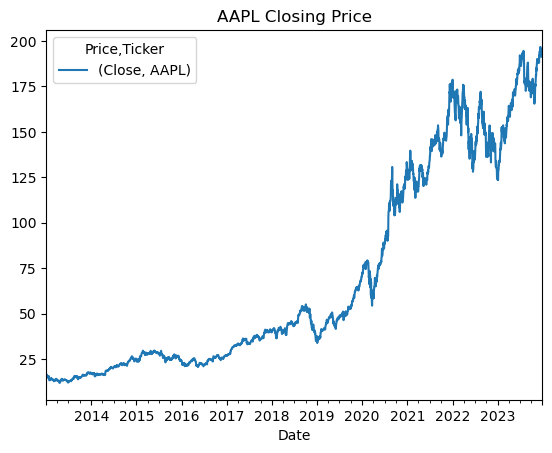

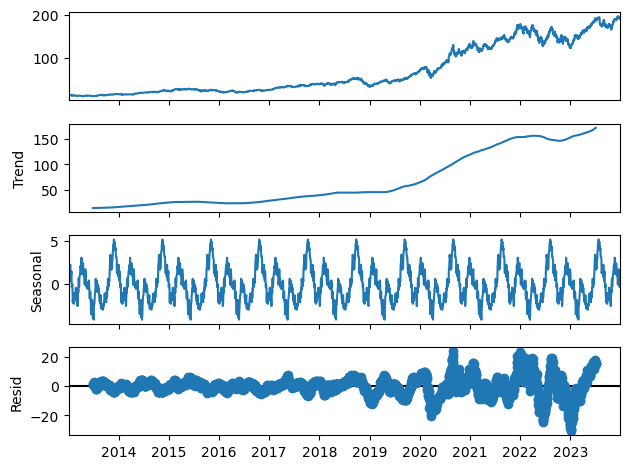

In [3]:
df.plot(title='AAPL Closing Price')
plt.show()

# Seasonal Decomposition
decomp = seasonal_decompose(df['Close'], model='additive', period=252)  # yearly seasonality in trading days
decomp.plot()
plt.show()


In [4]:
# ADF Test
print("ADF Test:", adfuller(df['Close'])[1])  # p-value

# KPSS Test
print("KPSS Test:", kpss(df['Close'], regression='c')[1])  # p-value


ADF Test: 0.9875030096283489
KPSS Test: 0.01


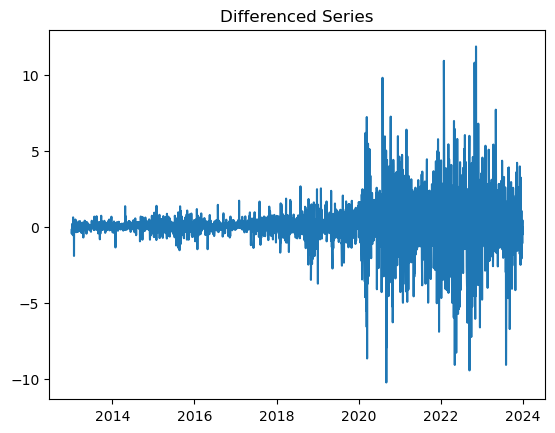

ADF (after diff): 7.695315757347105e-30


In [5]:
df_diff = df['Close'].diff().dropna()

plt.plot(df_diff)
plt.title("Differenced Series")
plt.show()

# Re-test Stationarity
print("ADF (after diff):", adfuller(df_diff)[1])


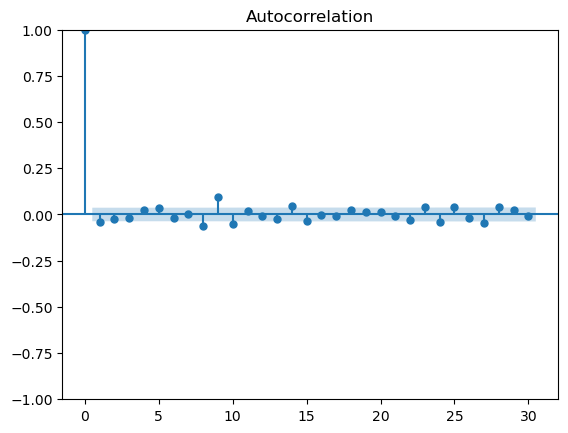

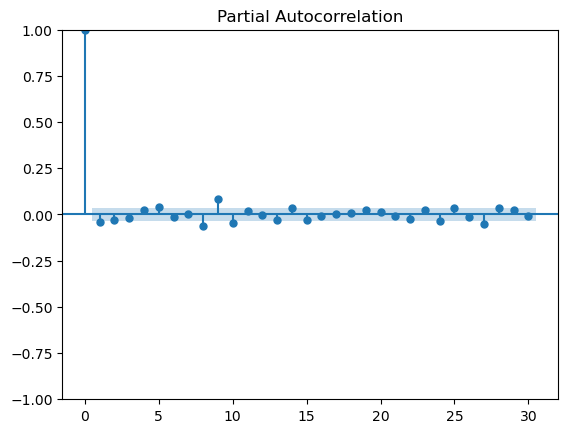

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_diff, lags=30)
plot_pacf(df_diff, lags=30)
plt.show()


In [7]:


# Set test size
test_size = 60

# --- Train/Test Split ---
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]


In [ ]:
# Backtesting ARIMA

model_arima = ARIMA(train['Close'], order=(1,1,1))
res_arima = model_arima.fit()
pred_arima = res_arima.forecast(steps=test_size)
pred_arima.index = test.index

rmse_arima = np.sqrt(mean_squared_error(test['Close'], pred_arima))
mape_arima = mean_absolute_percentage_error(test['Close'], pred_arima)


In [ ]:
# Backtesting SARIMA

model_sarima = SARIMAX(train['Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
res_sarima = model_sarima.fit()
pred_sarima = res_sarima.forecast(steps=test_size)
pred_sarima.index = test.index

rmse_sarima = np.sqrt(mean_squared_error(test['Close'], pred_sarima))
mape_sarima = mean_absolute_percentage_error(test['Close'], pred_sarima)


In [ ]:
# Backtesting PROHPHET

df_prophet = df.reset_index()[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']

train_prophet = df_prophet.iloc[:-test_size]
test_prophet = df_prophet.iloc[-test_size:]

model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=test_size, freq='B')
forecast_prophet = model_prophet.predict(future)

pred_prophet = forecast_prophet.set_index('ds').loc[test_prophet['ds']]

rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], pred_prophet['yhat']))
mape_prophet = mean_absolute_percentage_error(test_prophet['y'], pred_prophet['yhat'])


18:38:45 - cmdstanpy - INFO - Chain [1] start processing
18:38:46 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Forecasting ARIMA

full_model_arima = ARIMA(df['Close'], order=(1,1,1)).fit()
forecast_arima = full_model_arima.forecast(steps=60)


In [ ]:
# Forecasting SARIMA

full_model_sarima = SARIMAX(df['Close'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
forecast_sarima = full_model_sarima.forecast(steps=60)


In [ ]:
# Forecasting PROPHET

model_prophet_full = Prophet(daily_seasonality=True)
model_prophet_full.fit(df_prophet)

future_full = model_prophet_full.make_future_dataframe(periods=60, freq='B')
forecast_full_prophet = model_prophet_full.predict(future_full)
forecast_60_prophet = forecast_full_prophet.set_index('ds').tail(60)


18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:08 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# EVALUATING ALL MODELS WITH RMSE AND MAPE

results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet'],
    'RMSE': [rmse_arima, rmse_sarima, rmse_prophet],
    'MAPE': [mape_arima, mape_sarima, mape_prophet]
})

print("Model Comparison (60-Day Test Set):\n")
print(results.sort_values(by='RMSE'))


Model Comparison (60-Day Test Set):

     Model       RMSE      MAPE
1   SARIMA   9.805428  0.045661
0    ARIMA  12.297591  0.055828
2  Prophet  15.862387  0.074613


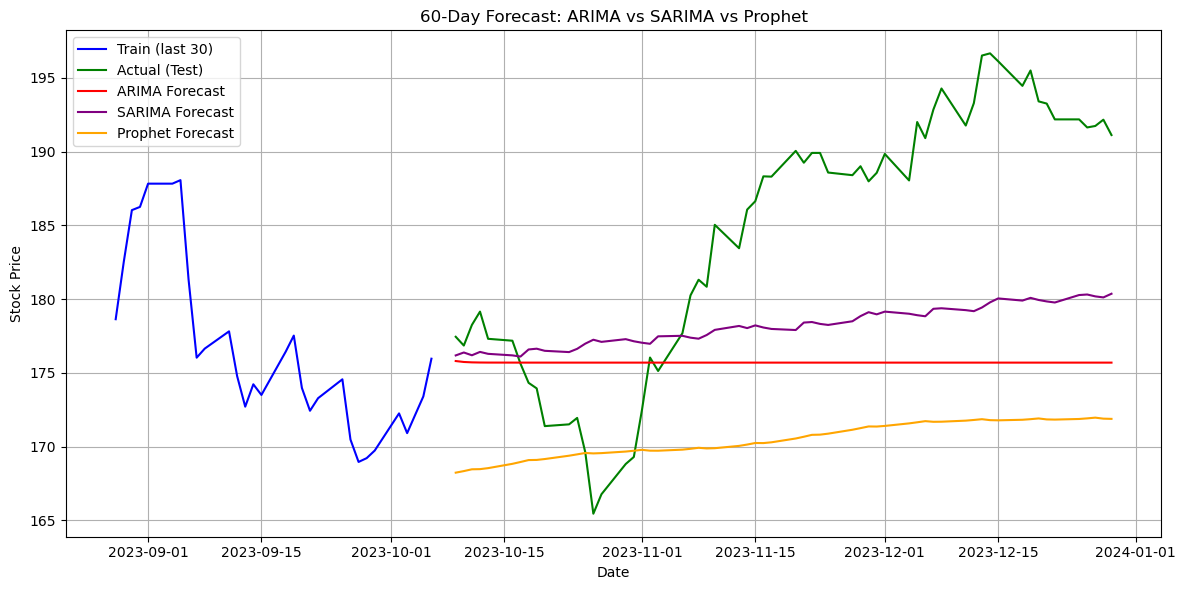

In [15]:
plt.figure(figsize=(12,6))
plt.plot(train.index[-30:], train['Close'].tail(30), label='Train (last 30)', color='blue')
plt.plot(test.index, test['Close'], label='Actual (Test)', color='green')
plt.plot(pred_arima.index, pred_arima, label='ARIMA Forecast', color='red')
plt.plot(pred_sarima.index, pred_sarima, label='SARIMA Forecast', color='purple')
plt.plot(test_prophet['ds'], pred_prophet['yhat'], label='Prophet Forecast', color='orange')

plt.title('60-Day Forecast: ARIMA vs SARIMA vs Prophet')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
